# Sistemas Autônomos

## Lista 2



## Importações e funções auxiliares.

A função de prob foi reutilizada do trabalho 1. A função plot_robot_v3 retorna objetos do tipo patches para auxiliar a graficação e apresentação dos cenários. A terceira função implementa um plot auxiliar para gerar os scans.

A quarta função implementa uma verificação da intersecção de dois seguimentos de reta a partir de equações de geometria analítica. Esta função retorna os as coordenadas da intersecção caso esta aconteça, caso contrário é retornado um Not a Number (np.nan).


In [ ]:
import numpy as np
from numpy import sin, cos, sqrt, pi, arctan2
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle, Wedge, ConnectionPatch
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import shapely.geometry as shp


def prob(dist, sigma):
  p = np.exp(-.5 * dist ** 2 / sigma ** 2) / sqrt(2 * pi * sigma**2)
  return p

def plot_robot_v3(pose, radius=0.3):
  center = (pose[0], pose[1])
  ang = pose[2] * 180 / np.pi

  circ = Circle(center, radius, fill=False, color='black', zorder=2)
  wed = Wedge(center, radius, ang-2, ang+2, color='black', zorder=2)

  return [circ, wed]

def plot_scans(pose, intersections):
  center = (pose[0], pose[1])
  lines = []
  for i in range(len(intersections)):
    ray_final = intersections[i]
    # print(ray_final)
    lin = ConnectionPatch(center, ray_final, coordsA="data",
                          arrowstyle="->", color='green')
    lines.append(lin)

  return lines


def line_intersection(p1, p2, q1, q2):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = q1
    x4, y4 = q2
    # Calculate the direction vectors of the two line segments
    dx1 = x2 - x1
    dy1 = y2 - y1
    dx2 = x4 - x3
    dy2 = y4 - y3

    # Calculate the determinant of the direction vectors
    det = dx1 * dy2 - dx2 * dy1

    # Check if the line segments are parallel (det == 0)
    if det == 0:
        return np.nan  # No intersection

    # Calculate the parameters for the intersection point
    t1 = ((x3 - x1) * dy2 - (y3 - y1) * dx2) / det
    t2 = ((x3 - x1) * dy1 - (y3 - y1) * dx1) / det

    # Check if the intersection point is within both line segments
    if 0 <= t1 <= 1 and 0 <= t2 <= 1:
        intersection_x = x1 + t1 * dx1
        intersection_y = y1 + t1 * dy1
        return intersection_x, intersection_y
    else:
        return np.nan  # Intersection point is outside one or both line segments



## Função de calibração dos parâmetros

Para elaboração da função de calibração *learn_intrinsic_parameters*. O algoritmo obtém um vetor de parâmetros $ \Theta = [z_{hit}, z_{max}, z_{short}, z_{rand}, \sigma_{short}, \lambda_{short} ]$ a partir de um vetor de estados $ X $ e um vetor de leituras $ Z $. Os estados são considerados apenas com uma medição sendo assim, $ z^k $ é considerado escalar. Foi considerado um sensor com fundo de escala $ max_z = 10m $.

 Por simplificação e considerando que o estado é unidimensional, então $ z^{k,*}_i = x_i $ de forma a dispensar o uso do * ray casting * para fins de calibração do sensor. Com estas simplificações consideradas, o efeito do mapa nas leituras não foi abordado.

A função permite o ajuste do $ \sigma_{hit} $ e do $ \lambda_{short}$, porém são definidos como valores *default*, respectivamente, 0.1 e 1 para estes parâmetros. O critério de parada para convergência do algoritmo foi considerado $ || \Theta - \Theta_{prévio} || < tol  $, onde $\Theta_{prévio} $ é o resultado da iteração anerior e tol é uma tolerancia definida na entrada da função, sendo o valor *default* igual a 0.01.  


In [ ]:
def learn_intrinsic_parameters(Z, X, tol=0.01, m=None,
                               sigma0=0.1, lambda0=1, max_z=10):
    sigma = sigma0
    lbd = lambda0

    z_hit, z_max, z_short, z_rand = .25, .25, .25, .25
    theta = np.array((z_hit, z_max, z_short, z_rand, sigma, lbd))

    err = np.inf
    norm_Z = np.linalg.norm(Z)

    e_hit = np.zeros(len(Z))
    e_max = np.zeros(len(Z))
    e_short = np.zeros(len(Z))
    e_rand = np.zeros(len(Z))

    chk = 0

    while err > tol:
        theta_prev = theta
        for idx in range(len(Z)):
            z = Z[idx]
            x = X[idx]

            # considerando ray casting perfeito z* = x

            # hit e rand
            if z < max_z:
                eta_hit = (norm.cdf((x - max_z)**2 / sigma ** 2)) ** -1

                p_hit = eta_hit * np.exp(-.5*(z - x)**2/sigma**2) / np.sqrt(2 * np.pi * sigma ** 2)
                p_rand = 1 / max_z

            else:
                p_hit = 0
                p_rand = 0

            # short
            if z < x:
                eta_short = 1 / (1 - np.exp(- lbd * x))
                p_short = eta_short * lbd * np.exp( - lbd * z)

            else:
                p_short = 0

            # max
            if z >= max_z:
                p_max = 1
            else:
                p_max = 0

            eta = (p_hit + p_max + p_short + p_rand)**-1

            e_hit[idx] = eta * p_hit
            e_max[idx] = eta * p_max
            e_short[idx] = eta * p_short
            e_rand[idx] = eta * p_rand

        # norm_Z = np.linalg.norm(np.array([z_hit, z_max, z_short, z_rand]))

        z_hit = norm_Z ** -1 * e_hit.sum()
        z_max = norm_Z ** -1 * e_max.sum()
        z_short = norm_Z ** -1 * e_short.sum()
        z_rand = norm_Z ** -1 * e_rand.sum()

        sigma = np.sqrt((e_hit * (Z - X)**2).sum() / e_hit.sum())
        lbd = e_short.sum() / (e_short * Z).sum()

        Z_all = np.array([z_hit, z_max, z_short, z_rand])
        z_hit, z_max, z_short, z_rand = Z_all / Z_all.sum()

        theta = np.array((z_hit, z_max, z_short, z_rand, sigma, lbd))
        err = np.linalg.norm(theta - theta_prev)
        chk = chk + 1
        print(chk, '\t', err, '\t', theta)

    return theta

### Teste da função

Para se obter uma população adequada para o emprego do algorigmo foi necessário implementar algumas outras funções. Foi criada uma função build_pdf que recebe os parametros zstar, maxz e o conjunto de parâmetros $\Theta$ anteriormente descrito e responde com uma nova função da pdf de z. Foi implementado o algoritmo de *rejection_sampling*.

Com estas funções foram obtidas pdf para um $\Theta_{target} = [0.65, 0.10, 0.15, 0.10, 0.35,  1.1] $ para 22 situações diferentes em que o sensor deveria ter uma leitura entre $0$ e $10.5m$ (posições equiespaçadas neste intervalo). Para cara situação dessa fora realizadas 100 medidas de acordo com a pdf configurada através do rejection sampling. Com esta população de leituras, então o algoritmo do leaning_intrinsic_parameters foi empregado para tentar recuperar os parâmetros. Considerou-se a leitura máxima como $max_z = 10 m$.
Com o algoritmo implementado, a partir destas 22000 amostras, em 6 iterações o algoritmo obteve $ \Theta_{learned} = [0.6045, 0.0118, 0.1645, 0.2191, 0.3239, 1.3539] $. Desta forma, notou-se que o algoritmo recuperou valores aproximados porém com alguma dificuldade em recuperar o parâmetro $z_{max}$.


Sampling when robot is on x=0.0
Sampling when robot is on x=0.5


<ipython-input-3-879959b36e7a>:6: RuntimeWarning: divide by zero encountered in double_scalars
  eta_short = 1 / (1 - np.exp(- lbd * zstar))


Sampling when robot is on x=1.0
Sampling when robot is on x=1.5
Sampling when robot is on x=2.0
Sampling when robot is on x=2.5
Sampling when robot is on x=3.0
Sampling when robot is on x=3.5
Sampling when robot is on x=4.0
Sampling when robot is on x=4.5
Sampling when robot is on x=5.0
Sampling when robot is on x=5.5
Sampling when robot is on x=6.0
Sampling when robot is on x=6.5
Sampling when robot is on x=7.0
Sampling when robot is on x=7.5
Sampling when robot is on x=8.0
Sampling when robot is on x=8.5
Sampling when robot is on x=9.0
Sampling when robot is on x=9.5
Sampling when robot is on x=10.0
Sampling when robot is on x=10.5
begin the learning with 22000 points
1 	 0.4845214351471672 	 [0.55871961 0.01186229 0.19598822 0.23342988 0.28712976 0.77959469]
2 	 0.2426133087534404 	 [0.58471001 0.01186351 0.18192205 0.22150443 0.3080706  1.01919253]
3 	 0.1619620410575683 	 [0.59633194 0.01186362 0.17339788 0.21840656 0.31769014 1.18019514]
4 	 0.09478597525778805 	 [0.60133716 0.01

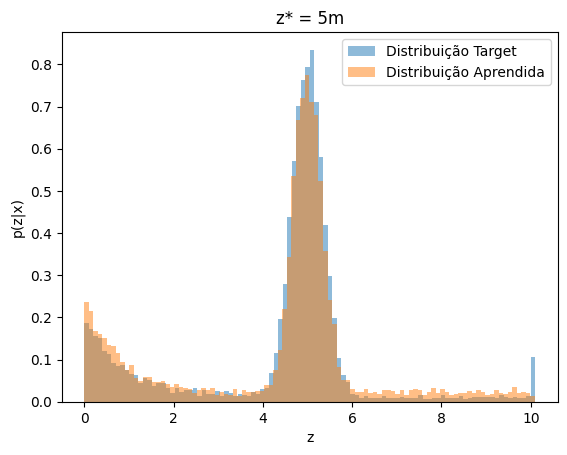

In [ ]:
def build_pdf(zstar, max_z, theta_params):
    z_hit, z_max, z_short, z_rand, sigma, lbd = list(theta_params)

    eta_hit = (norm.cdf(x=max_z, loc=zstar, scale=sigma) -
               norm.cdf(x=0, loc=zstar, scale=sigma)) ** -1
    eta_short = 1 / (1 - np.exp(- lbd * zstar))

    def pdf(z):

        # hit e rand
        if z < max_z:

            p_hit = eta_hit * np.exp(-.5*(z - zstar)**2/sigma**2) / np.sqrt(2 * np.pi * sigma ** 2)
            p_rand = 1 / max_z

        else:
            p_hit = 0
            p_rand = 0

        # short
        if z < zstar:
            p_short = eta_short * lbd * np.exp(- lbd * z)

        else:
            p_short = 0

        # max
        if z >= max_z:
            p_max = 1
        else:
            p_max = 0

        p = p_hit * z_hit + p_max * z_max + \
            p_short * z_short + p_rand * z_rand

        return p

    return pdf


def rejection_sampler(n_samples, interval, pdf):
    min_x, max_x = interval

    x = np.linspace(0, 10, 100)
    max_p = -np.inf
    for xi in x:
        p = sensor_distribution(xi)
        if p > max_p:
            max_p = p

    samples = []
    while len(samples) < n_samples:
        x = np.random.uniform(min_x, max_x)
        acceptance_prob = pdf(x) / max_p
        if acceptance_prob > np.random.uniform(0, 1):
            samples.append(x)

    return samples

np.random.seed(2)
            # z_{hit, max, short, rand}, sigma, lbd
theta_target = [0.65, 0.10, 0.15, 0.10, 0.35,  1.1]
max_z = 10

sensor_distribution = build_pdf(zstar=5, max_z=max_z, theta_params=theta_target)
samples_target = rejection_sampler(10000, interval=[0, max_z+.1], pdf=sensor_distribution)

x_calib_list = np.linspace(0, 10.5, 22)

x_calib = []
z_sampled = []
for x_real in x_calib_list:
    print(f'Sampling when robot is on x={x_real}')

    sensor_distribution = build_pdf(zstar=x_real, max_z=max_z, theta_params=theta_target)
    samples = rejection_sampler(1000, interval=[0, max_z+.1], pdf=sensor_distribution)

    for s in samples:
        x_calib.append(x_real)
        z_sampled.append(s)

print(f'begin the learning with {len(x_calib)} points')

x_calib = np.array(x_calib)
z_sampled = np.array(z_sampled)
theta = learn_intrinsic_parameters(Z=z_sampled, X=x_calib,
                                    sigma0=0.25, lambda0=0.5, tol=0.05)

print(f'theta = {theta}')
print(f'target= {theta_target}')

sensor_distribution = build_pdf(zstar=5, max_z=max_z, theta_params=theta)
samples_learned = rejection_sampler(10000, interval=[0, max_z+.1], pdf=sensor_distribution)

plt.hist(samples_target, 100, label="Distribuição Target", alpha=0.5, density=True)
plt.hist(samples_learned, 100, label="Distribuição Aprendida", alpha=0.5, density=True)
plt.title('z* = 5m')
plt.legend()
plt.xlabel("z")
plt.ylabel('p(z|x)')
plt.show()


## Ray Casting

Para implementação do ray casting inicialmente foi declarada uma classe que deve armazenar as características do mapa. Objetos desta classe possuem uma lista de obstáculos poligonais convexos. Para sua definição espera-se que o usuário defina os obstáculos por uma sequência ordenada de seus vértices.

Os landmarks são armazendos em um dicionário que tem como chave seu identificador e como valor as coordenadas em tuplas.
O último parâmetro do do construtor da classe recebe os limites da área do mapa na forma de um poligono da mesma forma que os obstáculos.

Os objetos da classe tem ainda acesso a uma função que retorna objetos do tipo patch para facilitar a visualização do mapa. Os obstáculos serão apresentados em preto e os landmarks como circulos vermelhos. Por último foi implementada nesta classe uma função para indicar a ocupação ou não de um ponto no mapa.



In [ ]:
class Map:
    def __init__(self, obstacles, landmarks, area_limit):
        """
        obstacles: deve ser uma lista de obstaculos.
                    o obstáculo é um polígono e deve ser convexos, definidos por pontos sequenciais.
        landmarks: é construído como um dicionário, com a key inteira e sequencial definindo como um identificador
                    o value da entrada do dicionário deve ser uma tupla (x_i, y_i)
        area_limit: deve ser um poligono convexo, conforme os obstacles
        """

        self.obstacles = obstacles
        self.landmarks = landmarks
        self.area_limit = area_limit

    def get_patches(self):
        patches = []
        background = Polygon(np.array(self.area_limit), color='white', zorder=-1)
        patches.append(background)

        for obs in self.obstacles:
          pat = Polygon(np.array(obs), closed=True, color='black')
          patches.append(pat)

        for ldmk_id in self.landmarks.keys():
          pat = Circle(np.array(self.landmarks[ldmk_id]), color='red', radius=0.5,
                      label=ldmk_id)
          patches.append(pat)

        return patches

    def point_is_occupied(self, point):
        occupied = False
        for obst in obstacles:
            occupied = occupied or shp.polygon.Polygon(obst).contains(shp.Point(point))
            if occupied:
                break

        return occupied



Para codificação do raycasting foi implementada uma função que recebe os mapa, necessariamente da classe anterior. A implementação aceita somente um xt por vez. Devem ser passados ainda as angulações de cada um dos scanners em relação a frente do robot, para isso espera-se que o usuário passe uma lista de desvios, em radianos, em relação a frente do robô. É necessário também o alcance máximo de varedura de cada feixe.

In [ ]:
def ray_casting(m, xt, delta_theta_sensors, max_range):
    """
    m:                      mapa que implementa a classe acima.
    xt:                     estado do robô
    delta_theta sensors:    lista com o desvio angular de cada um dos sensores em relação a frente do robô
    max_range:              alcance máximo dos sensores do robô
    """
    assert type(m) == Map
    x = xt[0]
    y = xt[1]
    theta = xt[2]

    K = len(delta_theta_sensors)

    z_star = np.zeros(K)
    intersections = [[np.nan, np.nan]] * K

    for k in range(K):
        theta_k = theta + delta_theta_sensors[k]
        ray_origin = [x, y]
        ray_final = [x + max_range * cos(theta_k), y + max_range * sin(theta_k)]

        zk = max_range
        intersectionk = ray_final

        for obstacle in m.obstacles:
            for point_idx in range(len(obstacle)):
                p1 = obstacle[point_idx]
                p2 = obstacle[point_idx - 1]
                intersection = line_intersection(ray_origin, ray_final, p1, p2)
                if intersection is np.nan:
                    continue
                zk_obst = np.sqrt((x - intersection[0])**2 + (y - intersection[1])**2)
                if zk_obst < zk:
                    zk = zk_obst
                    intersectionk = intersection

            z_star[k] = zk
            intersections[k] = intersectionk

    return z_star, intersections


Para teste do ray casting foi implementado um mapa de exemplo que foi utilizado posteriormente ao longo do trabalho. O mapa representa uma área de 20 x 20 m, com paredes o circunscrevendo. Há ainda uma pilastra retangular e dois landmarks como reprensentado na figura a seguir (saída da próxima célula de código).

O robô foi colocado nas proximidades da pilastra. Sendo dotado de 6 sensores, um voltado para frente, uma para trás e dois pares simétricis situados a 30° e 45° em relação a frente do robô. Os feixes são representados graficamente pelas setas em verde.

A célula a seguir responde ainda uma lista com os ângulos de com os ranges obtidos pelo algoritmos de maneira correta verificando a efetividade da função implementada.

delta_theta_sensores: [  0. 180.  60. -60.  45. -45.]
z_raycast = [ 5.          4.         10.          8.08290377 10.          9.89949494]


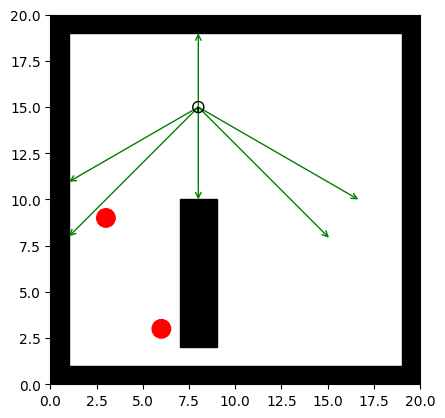

In [ ]:
obstacles = [[(0,0), (20, 0), (20, 1), (0, 1)],     # paredes
             [(0,0), (0, 20), (1, 20), (1, 0)],
             [(0,20), (0, 19), (20, 19), (20, 20)],
             [(19,20), (20, 20), (20, 0), (19, 0)],
             [(7, 2), (7, 10), (9, 10), (9, 2)]]      # pilar

area_limit = [(0, 0), (0, 20), (20, 20), (20, 0)]

landmarks = {1: (3, 9),
             2: (6, 3)}

example_map = Map(landmarks=landmarks, obstacles=obstacles, area_limit=area_limit)


xt = np.array((8, 15, 1.5*pi))[:,np.newaxis]
delta_theta_sensors = [0, pi , pi/3, -pi/3, pi/4, -pi/4]
delta_theta_sensors = np.arange(-45, 45, 5)*pi/180
max_range = 10

zkstar, intersections = ray_casting(example_map, xt, delta_theta_sensors, max_range)

print(f"delta_theta_sensores: {np.array(delta_theta_sensors)*180/pi}")
print(f"z_raycast = {zkstar}")

map_patches = example_map.get_patches()
robot_patches = plot_robot_v3(pose = xt.T[0], radius=0.3)
scans_patches = plot_scans(pose = xt.T[0], intersections=intersections)

all_patches = map_patches + robot_patches + scans_patches

fig, ax = plt.subplots()

for p in all_patches:
  ax.add_artist(p)

ax.axis('square')
ax.set_xlim((0, 20))
ax.set_ylim((0, 20))


plt.show()


## Função *beam_range_finder_model*

A função de modelo recebe as leituras realizadas pelos sensores e as posições de múltiplas amostras do mesmo robô. Portanto, todas as amostras apresentadm o mesmo $ \Theta_{params}, \Delta\theta_{sensors} $ e $ max_z $, entradas da função. As entradas $X_t$ e $Z_t $ devem ser organizadas de maneira que os estados $ X = [x, y, \theta]^T $ das amostras são dispostas lado a lado. As k leituras dos sensores de cada amostra são dispostas em colunas, ou seja $ Z_t = [z_1, z_2, ... z_K]^T $ e a organização do input segue a mesma disposição dos estados. A função recebe ainda o mapa com o qual serão realizados os cálculos do *ray cast* para cada uma das amostras.
Para cada uma das leituras de cada uma das amostras é calculada a sua probabilidade em função da leiutura e da sua posição. Devido a independência das leituras a probabilidade conjunta das leituras.
$q = P(Z_t | X_t, map) = ∏_{k=1}^K P(z_{t,k} | X_t, map) $

O q é calculado multiplicando a cada iteração de um loop que calcula a probabilidade da leitura em função do estado e da leitura esperada considerando o ray cast com o mapa passado para função.


In [ ]:
def beam_range_finder_model(zt, xt, theta_params, m, delta_theta_sensors, max_z=10):
    """
    inputs:
        zt: K x S -> são tratadas S amostras. As K leituras de cada amostra são consideradas colunas dispostas lado a lado.
        xt: 3 x S -> são tratadas S amostras. Os estados são colunas [x, y, theta].T dispostas lado a lado.
        m: Map -> mapa do cenário conforme classe implementada.
        theta_params: vetor de parâmetros dos sensores. com o seguinte ordernamento z_hit, z_max, z_short, z_rand, sigma_hit, lbd_short
        max_z:  range máximo do feixe.

    output:
        q: 1 x S -> vetor com as likelihoods de cada uma das amostras considerando suas leituras.
    """

    z_hit, z_max, z_short, z_rand, sigma, lbd = list(theta_params)
    K_scans, n_samples = zt.shape
    # verifica se as colunas tem o mesmo número de medidas do que de sensores.
    assert K_scans == len(delta_theta_sensors)

    # inicializa o vetor que armazena os valores de q para cada uma das amostras.
    lklhd = np.zeros(n_samples)

    # itera sobre as asmostras e extrai os x e z de cada uma delas.
    for s_idx in range(n_samples):
        x_i = xt[:, s_idx]
        z_i = zt[:, s_idx]

        # dado o mapa e o x é possíve descobrir o zstar com o raycasting
        zstar, _ = ray_casting(m, x_i, delta_theta_sensors, max_range)

        # q: probabilidade conjunta para amostra. será calculada em função da
        # probabilidade conjunta das probabilidades de cada uma das leituras em
        # função do z* esperado dado o estado hipotético e o mapa. O loop
        # iniciado implementa o calculo da likelihood conjunta.
        # Em cada iteração do loop é calculada o likelihood da medição e o
        # produtório é reproduzido ao multiplicar cada uma das probs pelo q acumulado.
        q = 1
        for k in range(K_scans):
            zstark = zstar[k]
            zik = z_i[k]

            eta_hit = (norm.cdf(x=max_z, loc=zstark, scale=sigma) -
                       norm.cdf(x=0, loc=zstark, scale=sigma)) ** -1
            eta_short = 1 / (1 - np.exp(- lbd * zstark))

            # hit e rand
            if zik < max_z:

                p_hit = eta_hit * np.exp(-.5 * (zik - zstark) ** 2 / sigma ** 2) / np.sqrt(2 * np.pi * sigma ** 2)
                p_rand = 1 / max_z

            else:
                p_hit = 0
                p_rand = 0

            # short
            if zik < zstark:
                p_short = eta_short * lbd * np.exp(- lbd * zik)

            else:
                p_short = 0

            # max
            if zik >= max_z:
                p_max = 1
            else:
                p_max = 0

            p = p_hit * z_hit + p_max * z_max + \
                p_short * z_short + p_rand * z_rand

            q = q * p

        lklhd[s_idx] = q

    return lklhd

### Teste da função *beam_range_finder_model*

Para observação do funcionamento da função beam range finder foi utilizado o mesmo example mapa. Neste foram colocados três robôs com os estados: $[8, 15, 1.5 \pi]^T, [8, 15, 0.5 \pi]^T$ e $[11, 11, 0]^T$. Para os três estados foram calculadas as likelihoods pelo modelo implementado considerando as leituras exatas do primeiro modelo. Os parâmetros $\Theta$ utilizados para o modelo do sensor foram os do modelo alvo utilizado para o teste da função de aprendizado dos parâmetros.

Observa-se que a likelihood apresenta valores baixos para todos os cenários. No entanto, isso é esperado uma vez que é uma multiplicação de 5 probabilidades, uma associada a cada leitura. Observa-se ainda que a leitura do teceiro cenário é a menor, seguida do segundo cenário no qual há adequação de x e y porém não ed $ \theta $. Por fim, o cenário correto apresenta a maior likelihood sendo igual a 5.16e-03.



In [ ]:
delta_theta_sensors = [0, pi, pi / 3, -pi / 3, pi / 4, -pi / 4]
theta_target = [0.65, 0.10, 0.15, 0.10, 0.35, 1.1]
max_range = 10

xt = np.array([[8,      8,      11],
                [15,     15,     11],
                [1.5*pi, .5*pi,  0]])

zt = np.array([[5., 4., 10., 8.08290377, 10., 9.89949494],      # leitura correta do primeiro estado para cada
                [5., 4., 10., 8.08290377, 10., 9.89949494],
                [5., 4., 10., 8.08290377, 10., 9.89949494]]).T


lklhds = beam_range_finder_model(zt, xt, theta_params=theta_target, m=example_map, delta_theta_sensors=delta_theta_sensors, max_z=max_range)

print(lklhds)


[5.15946140e-03 4.03403932e-08 1.84241134e-08]


## Função *likelihood_field_range_finder_model*

A função implementa o cálculo do likelihood considerando os pontos finais das leituras no mapa. Para isto as posições de cada um dos sensores em relação ao robô é levada em consideração e a partir das leiuras é feito o cálculo da posição do final do feixe e o objeto detectado no mapa. Então calcula-se a probabilidade de cada uma das leituras em função da distância desde ponto ao ponto ocupado mais próximo no mapa pela função:

$ q = P(Z_t | X_t, map) = ∏_{k=1}^K P(z_{t,k} | X_t, map) = ∏_{k=1}^K (z_{hit} * prob (dist_k, \sigma_{hit}) + z_{rand} / z_{max}) $

Para fins de implementação as entras são as mesmas que a da função de modelo anterior. É adicionada somenta a variável $xy_{sens}$ que indica as posições relativas dos sensores no referêncial do robô.

A implementação conta com um loop externo análogo ao da *beam_range_finder_model*. No entanto, há mudança no cálculo das probabilidades de cada uma das medição que passam a ser implementadas conforme a fórmula apresentada.

In [ ]:
def likelihood_field_range_finder_model(Z_t, x_t, m, xy_sens, delta_theta_sensors, theta_params, max_z=10):
    """
    inputs:
        zt: np.array, K x 1 -> As K leituras de cada sensor são consideradas como uma coluna.
        xt: np.array, 3 x S -> Ssão tratadas S amostras. Os estados são colunas [x, y, theta].T dispostas lado a lado.
        xy_sens: np.array, 2 x K -> posições relativas de cada um dos sensores no referencial do corpo do robo.
        m: Map -> mapa do cenário conforme classe implementada.
        theta: vetor de parâmetros dos sensores. com o seguinte ordernamento z_hit, z_max, z_short, z_rand, sigma_hit, lbd_short
        max_z:  range máximo do feixe.

    output:
        q: 1 x S -> vetor com as likelihoods de cada uma das amostras considerando suas leituras.
    """

    z_hit, z_max, z_short, z_rand, sigma_hit, lbd = list(theta_params)
    # zt = np.array(zt)
    K_scans, _ = Z_t.shape
    n_states, n_samples = xt.shape


    # verifica se o número de leituras passado é coerente ao número de sensores na lista de delta_theta
    assert K_scans == len(delta_theta_sensors)

    # verifica se o número de posições relativas de sensores passado é coerente com o número de scans.
    assert 2, K_scans == xy_sens.shape

    # inicializa o vetor que armazena os valores de q para cada uma das amostras.
    lklhds = np.zeros(n_samples)

    # itera sobre as asmostras e extrai os x e z de cada uma delas.
    for s_idx in range(n_samples):
        x_i = x_t[:, s_idx]
        z_i = Z_t[:, s_idx]

        x = x_i[0]
        y = x_i[1]
        theta = x_i[2]

        # dado o mapa e o x é possível descobrir as intersecções dos raios com
        # areas ocupadas do mapa <xl, yl> com a função implementada para o
        # raycasting (ausência de interseções corresponde a NaN). Considera-se
        # uma aproximação do algoritmo proposto considerar que o <xl, yp> está
        # na direção do raio.
        _, intersections = ray_casting(m, x_i, delta_theta_sensors, max_range)

        q = 1
        for k in range(K_scans):
            zk = z_i[k]
            thetak = delta_theta_sensors[k]
            xksens = xy_sens[0, k]
            yksens = xy_sens[1, k]

            if zk < max_range:
                xzk = x + xksens * cos(theta) - yksens * sin(theta) + zk * cos(theta + thetak)
                yzk = y + yksens * cos(theta) + xksens * sin(theta) + zk * sin(theta + thetak)

                xl = intersections[k][0]
                yl = intersections[k][1]

                dist = sqrt((xzk - xl)**2 + (yzk - yl)**2)
                q = q * (z_hit * prob(dist, sigma_hit) + z_rand / z_max)

        lklhds[s_idx] = q

    return lklhds

### Teste da Função
Retomou-se o mapa utilizado para a realização do teste da função implmentada conforme plot da próxima célula. Para o teste são analisadas as likelihoods de quatro partículas nas mesmas posições porém a primeira recebe as leituras ideais e nas demais as leituras são contaminadas com ruídos gaussianos de diferentes $\sigma$s.
O range máximo foi aumentado para 12 m para reduzir os caso nos quais os ruídos retiram a leitura de fim de curso pelo ruído analisado e permite compara melhor as likelihoods considerando os ruídos.

Likelihoods, em ordem: sigma:
sigma = [0, 0.1, 0.5 1,0]
[9.18518955 8.86745061 7.82350514 4.01882503]


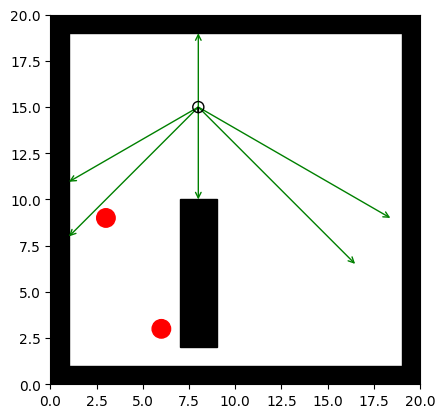

In [ ]:
delta_theta_sensors = [0, pi, pi / 3, -pi / 3, pi / 4, -pi / 4]
theta_target = [0.65, 0.10, 0.15, 0.10, 0.35, 1.1]
max_range = 12

xt = np.array((8, 15, 1.5 * pi))[:, np.newaxis]

zt_ideal, intersections = ray_casting(example_map, xt, delta_theta_sensors, max_range)

zt_ideal = np.array(zt_ideal)[:, np.newaxis]
zt_sig01= np.random.normal(zt_ideal, 0.1)
zt_sig05 = np.random.normal(zt_ideal, 0.5)
zt_sig1 = np.random.normal(zt_ideal, 1)

zt = [zt_ideal, zt_sig01, zt_sig05, zt_sig1]
# xt = np.hstack((xt, xt, xt, xt))

xy_sens = np.zeros((2, len(delta_theta_sensors)))

lklhds = np.zeros(len(zt))
for i in range(len(zt)):
  lklhds[i] = likelihood_field_range_finder_model(zt[i], xt, example_map, xy_sens, delta_theta_sensors,
                                                  theta_params=theta_target, max_z=10)

print("Likelihoods, em ordem: sigma:")
print("sigma = [0, 0.1, 0.5 1,0]")
print(lklhds)


### PLOT
map_patches = example_map.get_patches()
robot_patches = plot_robot_v3(pose=xt.T[0], radius=0.3)
scans_patches = plot_scans(pose=xt.T[0], intersections=intersections)

all_patches = map_patches + robot_patches + scans_patches

fig, ax = plt.subplots()

for p in all_patches:
    ax.add_artist(p)

ax.axis('square')
ax.set_xlim((0, 20))
ax.set_ylim((0, 20))
plt. show()

## Função *landmark_model_known_correspondence*

Função dedicada a retornar as likelihoods a partir do mapa e um ângulo e distância conhecidos de um landmark. A função inicia realizando um lookup em seu mapa para obter as coordenadas do landmark. Dada a leitura passada e a posição do landmark conhecido, cada uma das amostras passadas pelo parâmetro xt é verificada e tem sua likelihood conjunta computada em função das incertezas de leituras passadas no parâmetro sigmas.
A função retorna um vetor com as likelihoods de cada da uma das amostras, com o mesmo indice da coluna correspondente em xt.

In [ ]:
def landmark_model_known_correspondence(fit, cit, xt, m, sigmas):
    """
    inputs:
        cit: int -> indice do landmark no mapa.
        xt: 3 x S -: São tratadas S amostras. Cada uma correspondente a uma coluna [x, y, theta]^T.
        fit: 3 x 1 -> A leitura do landmark corresponde a colunas [r, phi, s].T.
        sigmas: 3 x 1 -> são obtidas os desvios padrão para cada uma das medições relativas dos landmarks.
        m: Map -> mapa do cenário conforme classe implementada.

    output:
        q: 1 x S -> vetor com as likelihoods de cada uma das amostras considerando a leitura realizada.
    """
    assert type(m) == Map
    mjx, mjy = m.landmarks[cit]       # lookup da posição do landmark no map

    x = xt[0, :]                        # estado hipotético do robô
    y = xt[1, :]
    theta = xt[2, :]

    rit = fit[0]
    phiit = fit[1]
    # sit = fit[2]                    # não utlizado -> considerando a leitura perfeita dos atributos.

    sigma_r = sigmas[0]               # obtenção variância de r e phi
    sigma_phi = sigmas[1]
    # sigma_s = sigmas[2]             # não utlizado -> considerando a leitura perfeita dos atributos.

    rhat = sqrt((mjx - x)**2 + (mjy - y)**2)
    phihat = arctan2(mjy - y, mjx - x) - theta

    q = prob(abs(rit - rhat), sigma_r) * prob(abs(phiit - phihat), sigma_phi)

    return q


### Teste da função

Para teste da função foi criada uma leitura do sensor indicando que o landmark estava a 6m do robot com um azimute de -π/2. Então, foram criadas três amostras de robots na variável $x_t$. As duas primeira se encontram na mesma posição com a distância adequada porém a primeira apresenta a posição coerente com a leitura do azimute e a segunda não. A terceira amostra consiste em um teste de sanidade e encontra-se em outro ponto diferente do mapa.

A célula retora uma ilustração das amostras e também o likelihood delas na ordem que são dispostas no $x_t$. A primeira amostra apresenta o maior likelihood coerente com a sua adequação a leitura informada. A segunda amostra, apresenta a parcela da likelihood associada a distância correta, e portanto, o segundo maior retorno da função. A terceira por sua vez apresenta o menor valor, coerente com sua posição muito descorrelacionada a leitura.

In [ ]:
xt = np.array([[3,          3,      10],
                [15,        15,     15],
                [0,         pi/2,  -pi/2]])

fit = np.array([[6, ],
                [-.5 * pi, ]])

sigmas = np.array([0.1, 0.1])

n_samples = len(xt[0])
cit = 1
q = landmark_model_known_correspondence(fit, cit, xt, m=example_map, sigmas=sigmas)

print("likelihoods das amostras:")
print(q)

map_patches = example_map.get_patches()
robot_patches = []
for i in range(len(xt.T)):
    robot_patches += plot_robot_v3(pose=xt.T[i], radius=0.3)

all_patches = map_patches + robot_patches

fig, ax = plt.subplots()

for p in all_patches:
    ax.add_artist(p)

ax.axis('square')
ax.set_xlim((0, 20))
ax.set_ylim((0, 20))
plt.show()

## Função *sample_landmark_model_known_correspondence*

A função retorna uma amostra de acordo com leitura da posição relativa de um landmark conhecido.

A função realiza no máximo 1000 tentativas de colocação de acordo com o algoritmo proposto verificando se o ponto (x, y) da amostra corresponde a um ponto desocupado no mapa.

In [ ]:
def sample_landmark_model_known_correspondence(fit, cit, m, sigmas):
    """
    inputs:
        cit: int -> indice do landmark no mapa.
        fit: np.array or list, 3 x 1 -> As leituras do landmark corresponde a coluna [r, phi, s].
        sigmas: np.array or list, 3 x 1 -> são obtidas os desvios padrão para cada uma das medições relativas dos landmarks.
        m: Map -> mapa do cenário conforme classe implementada.

    output:
        x_sample: 3 x 1 -> um estadod o tipo [x, y, theta]^T em posição não ocupada do mapa.
    """

    assert type(m) == Map
    mjx, mjy = m.landmarks[cit]       # lookup da posição do landmark no map

    rit = fit[0]
    phiit = fit[1]
    sit = fit[2]                # não utlizado -> considerando a leitura perfeita dos atributos.

    sigma_r = sigmas[0]         # obtenção variância de r e phi
    sigma_phi = sigmas[1]
    sigma_s = sigmas[2]         # não utlizado -> considerando a leitura perfeita dos atributos.

    watchdog = 0
    while True:
        watchdog += 1
        gammahat = np.random.uniform(0, 2 * pi)
        rhat = rit + np.random.normal(0, sigma_r)
        phihat = phiit + np.random.normal(0, sigma_phi)

        x = mjx + rhat * cos(gammahat)  # estado da amostra
        y = mjy + rhat * sin(gammahat)

        if not m.point_is_occupied((x, y)):
            break

        if watchdog == 1000:
            print("exceeded the number of tries")
            break

    theta = gammahat - pi - phihat

    x_sample = np.array((x, y, theta))[:, np.newaxis]
    return x_sample

In [ ]:
fit = np.array([5, pi/2, 0])
cit = 1
sigmas = [0.1, 0.1, 0]

samples = []
while len(samples) < 30:
    samples.append(sample_landmark_model_known_correspondence(fit, cit, m=example_map, sigmas=sigmas))

robot_patches = []
for robot in samples:
    robot_patches += plot_robot_v3(pose=robot.T[0])

map_patches = example_map.get_patches()

fig, ax = plt.subplots()
plt.figure(figsize=(10,6))

for p in map_patches + robot_patches:
    ax.add_artist(p)

ax.axis('square')
ax.set_xlim((0, 20))
ax.set_ylim((0, 20))

plt.show()

# código pro ray casting

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import math
# from numpy import cos, sin, pi, sqrt, arctan2, array, cov, random, shape
# from matplotlib import colors

In [ ]:
# def plot_robo(pose, radius):
#     span = np.linspace(0, 2*pi, 360)

#     for i in range(shape(pose)[1]):
#         a = radius*cos(span) + pose[0,i]
#         b = radius*sin(span) + pose[1,i]
#         plt.plot(a,b, 'black')
#         plt.grid(True)

#         endx = pose[0,i] + radius * math.cos(math.radians(pose[2,i]))
#         endy = pose[1,i] + radius * math.sin(math.radians(pose[2,i]))
#         plt.plot([pose[0,i], endx], [pose[1,i], endy], 'black')


# def to_pixels(pose_meters, res):
#     position_pixels = (pose_meters[0:2]/res).astype(int)
#     return np.vstack((position_pixels, pose_meters[2].astype(int)))


# def to_meters(pose_pixels, res):
#     position_meters = pose_pixels[0:2]*res
#     return np.vstack((position_meters, pose_pixels[2]))

# def ray_casting(pose, map, res, plot):

#     inc = 0
#     indx = 0
#     indy = 0

#     while map[pose[1] + indy, pose[0] + indx] == 0:
#         inc = inc + 1
#         indx = round(inc*cos(math.radians(pose[2])))
#         indy = round(inc*sin(math.radians(pose[2])))

#     medicao = sqrt(indx**2 + indy**2)
#     final = [pose[0] + indx, pose[1] + indy]

#     if plot ==1:
#         x_values = [res*pose[0], res*final[0]]
#         y_values = [res*pose[1], res*final[1]]
#         plt.gcf()
#         plt.plot(x_values, y_values, 'r', linestyle="--")

#     return res*medicao

In [ ]:
# M = 121
# x = ngp.linspace(0,6,M)
# y = np.linspace(0,6,M)
# res = 0.05
# map = np.ones((M,M))
# map[1:-1,1:-1]=0

# map[0:80,60]= 1 # obstáculo 1
# map[100, 0:60] = 1 # obstáculo 2

# cmap = colors.ListedColormap(['white','black'])
# plt.pcolor(x, y, map, cmap=cmap)

# pose = array([[4],[4],[0]])

# plot_robo(pose,0.2)
# ray_casting(to_pixels(pose, res), map, res, 1)